In [2]:
import os
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

from matplotlib import dates
import datetime

from heapq import nsmallest

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

import prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
import seaborn as sns
from neuralprophet import NeuralProphet, set_log_level

import warnings

In [3]:
holidays=['2020-01-01','2020-01-06','2020-04-12','2020-04-13','2020-05-01','2020-05-03',
          '2020-05-31', '2020-06-11','2020-08-15','2020-11-01','2020-11-11','2020-12-25',
          '2020-12-26','2021-01-01','2021-01-06','2021-04-04','2021-04-05','2021-05-01',
          '2021-05-03','2021-05-23','2021-06-03','2021-08-15','2021-11-01','2021-11-11',
          '2021-12-25','2021-12-26', '2022-01-01','2022-01-06', '2022-04-01','2022-04-02','2022-04-03','2022-04-04','2022-04-05',
          '2022-04-27','2022-04-28','2022-04-29','2022-04-30',
          '2022-05-01', '2022-05-02','2022-05-03','2022-05-04',
          '2022-05-23','2022-06-03','2022-08-15','2022-11-01','2022-11-11',
          '2022-12-25','2022-12-26'
         ]

state = pd.DataFrame({'ds': pd.to_datetime(holidays),
                      'holiday': 'state_holiday'
                      })
holidays = state

In [182]:
def quality_metrics(y, y_hat):
    print('MAE:', np.mean(np.abs(y - y_hat)))
    print('RMSE:', np.sqrt(np.mean(np.square(y - y_hat))))
    print('MAPE:', np.mean(np.abs((y - y_hat)/y)*100))
    print('MAX:', np.max(np.abs(y - y_hat)))
    mae = np.mean(np.abs(y - y_hat))
    rmse = np.sqrt(np.mean(np.square(y - y_hat)))
    mape = np.mean(np.abs((y - y_hat)/y)*100)
    maxi = np.max(np.abs(y - y_hat))
    return ([mae, rmse, mape, maxi])

In [31]:
path = os.getcwd()
files = os.listdir(path)
files_csv = [f for f in files if 'Utylizacja2' in f]
files_csv = sorted(files_csv)

In [29]:
df = pd.DataFrame()
for f in files_csv:
    data = pd.read_excel(f)
    df = df.append(data)

df.tail()

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3908/4265238994.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3908/4265238994.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3908/4265238994.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3908/4265238994.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_3908/426523899

,LTR Ilość na magazynie,LTR Ilość wynajęć,LTR Utylizacja,MTR Ilość na magazynie,MTR Ilość wynajęć,MTR Utylizacja,RAC Ilość na magazynie,RAC Ilość wynajęć,RAC Utylizacja,SK Ilość na magazynie,SK Ilość wynajęć,SK Utylizacja
238,3279,3226,0.9844,3066,2685,0.8933,3637,2443,0.7075,13143,9211,0.7228
239,3279,3226,0.9844,3066,2693,0.8960,3637,2376,0.6910,13144,9152,0.7204
240,3287,3230,0.9836,3071,2689,0.8984,3612,2469,0.7370,13119,9240,0.7343
241,3286,3235,0.9857,3086,2676,0.8908,3549,2500,0.7501,13085,9262,0.7348
242,3287,3233,0.9851,3095,2613,0.8701,3471,2443,0.7468,13014,9123,0.7273


In [34]:
# dodanie dat
idx = pd.date_range('2016-01-01', '2022-08-31')
df['ds'] = idx
df.set_index('ds', inplace=True)
df.head()


,LTR Ilość na magazynie,LTR Ilość wynajęć,LTR Utylizacja,MTR Ilość na magazynie,MTR Ilość wynajęć,MTR Utylizacja,RAC Ilość na magazynie,RAC Ilość wynajęć,RAC Utylizacja,SK Ilość na magazynie,SK Ilość wynajęć,SK Utylizacja
ds,,,,,,,,,,,,
2016-01-01,1533,1517,0.9902,2639,2197,0.8515,1695,1041,0.6614,5868,4755,0.8327
2016-01-02,1533,1517,0.9902,2639,2196,0.8515,1695,1009,0.6478,5868,4722,0.8287
2016-01-03,1533,1517,0.9902,2637,2203,0.8544,1697,957,0.6187,5868,4677,0.8216
2016-01-04,1533,1517,0.9902,2673,2248,0.8608,1648,1010,0.6729,5855,4775,0.8417
2016-01-05,1529,1516,0.9922,2742,2265,0.8483,1560,992,0.7083,5832,4773,0.8484


In [296]:
rac_ut = pd.DataFrame(df['RAC Utylizacja'])
rac_wyn = pd.DataFrame(df['RAC Ilość wynajęć'])
rac_mag = pd.DataFrame(df['RAC Ilość na magazynie'])
rac_ut = rac_ut.rename(columns={"RAC Utylizacja": "ut"})
rac_wyn = rac_wyn.rename(columns={'RAC Ilość wynajęć': 'wyn'})
rac_mag = rac_mag.rename(columns={'RAC Ilość na magazynie': 'mag'})

rac_ut = rac_ut.reset_index()
rac_ut_2016 = rac_ut[rac_ut['ds'].dt.year == 2016]
rac_ut_2017 = rac_ut[rac_ut['ds'].dt.year == 2017]
rac_ut_2018 = rac_ut[rac_ut['ds'].dt.year == 2018]
rac_ut_2019 = rac_ut[rac_ut['ds'].dt.year == 2019]
rac_ut_2020 = rac_ut[rac_ut['ds'].dt.year == 2020]
rac_ut_2021 = rac_ut[rac_ut['ds'].dt.year == 2021]
rac_ut_2022 = rac_ut[rac_ut['ds'].dt.year == 2022]
rac_ut_till_2020 = pd.concat([rac_ut_2016, rac_ut_2017, rac_ut_2018, rac_ut_2019])
rac_ut_after_2020 = pd.concat([rac_ut_2021, rac_ut_2022])

rac_ut_till_2020 = rac_ut_till_2020.rename(columns={"ut": "y"})
rac_ut_after_2020 = rac_ut_after_2020.rename(columns={"ut": "y"})
rac_ut_2020 = rac_ut_2020.rename(columns={"ut": "y"})
rac_ut_2021 = rac_ut_2021.rename(columns={"ut": "y"})


# rac_ut.set_index('ds', inplace=True)
# rac_ut_2016.set_index('ds', inplace=True)
# rac_ut_till_2020.set_index('ds', inplace=True)
# rac_ut_after_2020.set_index('ds', inplace=True)

In [150]:
plot_rac_ut = rac_ut_2016.reset_index()
plot_rac_ut['month_ds'] = plot_rac_ut['ds']
plot_rac_ut.head()
y_m_d = []
y_m = []
for id, row in plot_rac_ut.T.iteritems():
    y_m_d.append(str(row['month_ds'].month_name())+ " " + str(row['month_ds'].year)+str(row['month_ds'].day))
    y_m.append(str(row['month_ds'].month_name())+ " " + str(row['month_ds'].year))

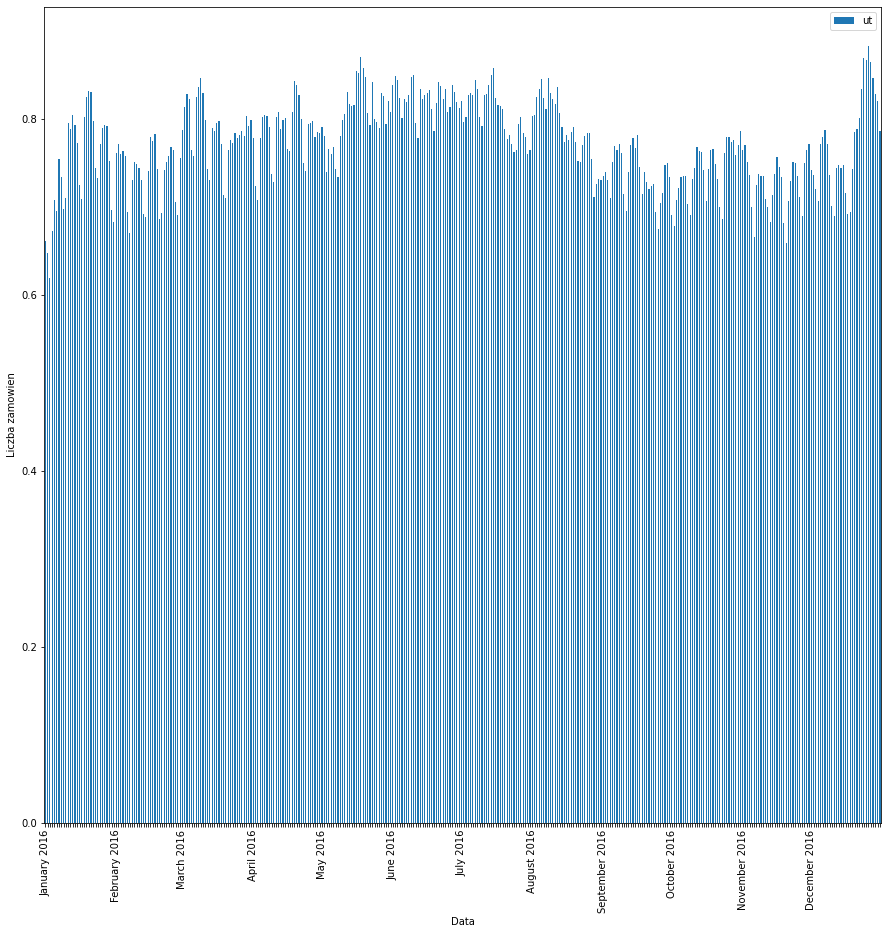

In [171]:
plot_rac_ut['month_ds'] = y_m_d
plot_rac_ut.head()

ax = plot_rac_ut.plot(x='month_ds', y='ut', style='o', xlabel="Data", ylabel="Liczba zamowien", kind="bar", figsize=(15,15))
ax.set_xticklabels(y_m)
prev_m = ""
temp_m = ""
temp_prev_m = ""
for i, m in enumerate(ax.get_xticklabels()):
    m_start = str(m).find("'")
    m_end = str(m).rfind("'")
    prev_m_start = str(prev_m).find("'")
    prev_m_end = str(prev_m).rfind("'")
    temp_prev_m = str(prev_m)[prev_m_start+1:prev_m_end]
    temp_m = str(m)[m_start+1:m_end]
    
    if str(temp_prev_m) == str(temp_m):        
        m.set_visible(False)
    else:
        m.set_visible(True)
        prev_m = m

In [179]:
# predykcja trendu
# Model Prophet
model_prophet = prophet.Prophet(
                          changepoint_prior_scale = 0.05,
                          seasonality_prior_scale = 10,
                          changepoint_range=0.8,
                          yearly_seasonality=True,
                          weekly_seasonality=True,
                          daily_seasonality=True,
                          seasonality_mode = 'multiplicative',
                          holidays = holidays
                           )
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [283]:
# predykcja trendu
# Model NeuralProphet
model_neuralprophet = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=3,
    n_forecasts=1,
    ar_reg=10,
    num_hidden_layers=1,
    d_hidden=10,
    learning_rate = 0.05,
    epochs = 100,
    seasonality_mode = 'multiplicative',
#     seasonality_reg = 1,
)

model_neuralprophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
# neural_model_2 = neural_model_2.add_events(["state", "may"])
# history_df = neural_model_2.create_df_with_events(wwa_train_3, events_df)

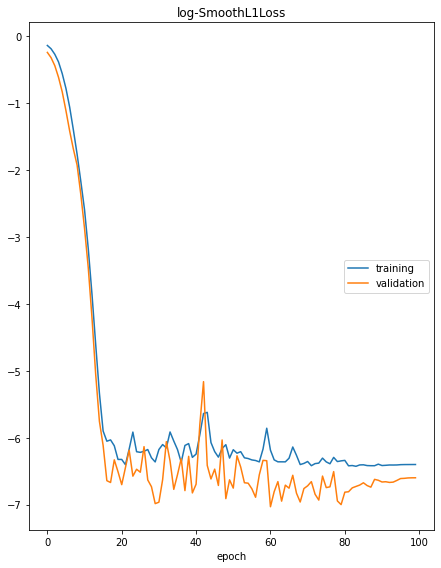

log-SmoothL1Loss
	training         	 (min:   -6.427, max:   -0.137, cur:   -6.400)
	validation       	 (min:   -7.031, max:   -0.241, cur:   -6.598)


In [297]:
# trenowanie modelu
# m = model_prophet
m = model_neuralprophet

# uczenie na danych do 2020 roku
df_train, df_test = m.split_df(rac_ut_2021[:-100], freq='D', valid_p = 0.2)

metrics = m.fit(df_train, 
                freq='D', 
                validation_df=df_test, 
                progress='plot')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:2098: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.836% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



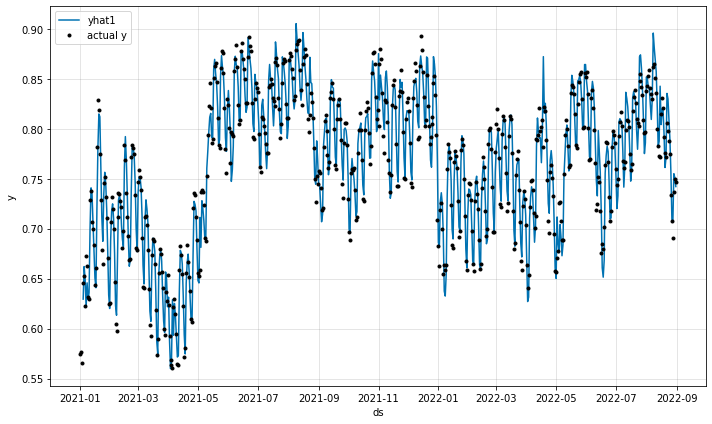

In [298]:
# predykcja
forecast = m.predict(rac_ut_after_2020)
fig = m.plot(forecast)

In [299]:
# wskazniki jakosci
real = rac_ut_till_2020['y']
pred = forecast['yhat1'].values

print("Metrics for last 120 days")
quality_metrics(real[-100:], pred[-100:])

Metrics for last 120 days
MAE: 0.05813704350185393
RMSE: 0.07302665186071902
MAPE: 7.832747673117389
MAX: 0.20833538303375243


[0.05813704350185393,
 0.07302665186071902,
 7.832747673117389,
 0.20833538303375243]